In [1]:
%config IPCompleter.greedy=True

In [2]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import numpy as np
import json
import seaborn as sns
import folium
import os
from shapely.geometry import Point, Polygon
from descartes import PolygonPatch
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.offsetbox import AnchoredText

Lets have a look at the model grid data contained in the Area Peril dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [3]:
area_peril_dictionary = pd.read_csv("./model_data/PiWind/areaperil_dict.csv")
area_peril_dictionary.head()

,areaperil_id,lon,lat,gridcell,peril
0,1,-0.914618,52.737027,1-1,windstorm
1,2,-0.908552,52.737027,2-1,windstorm
2,3,-0.902485,52.737027,3-1,windstorm
3,4,-0.896419,52.737027,4-1,windstorm
4,5,-0.890352,52.737027,5-1,windstorm


Lets plot the area peril cells on a map of the UK. For this model, the area perils are a simple uniform grid in a square.

In [4]:
m = folium.Map(location=[	52.737027, -0.914618], zoom_start=7, tiles='cartodbpositron')
num_cells = area_peril_dictionary.lat.count()
num_cells_per_side = math.sqrt(num_cells)
cell_size_lat = (max(area_peril_dictionary.lat) - min(area_peril_dictionary.lat)) / (num_cells_per_side - 1)
cell_size_lon = (max(area_peril_dictionary.lon) - min(area_peril_dictionary.lon)) / (num_cells_per_side - 1)
for i, row in area_peril_dictionary.iterrows():
    geometry = [Polygon([
        (row.lon, row.lat),
        (row.lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat + cell_size_lat),
        (row.lon + cell_size_lon, row.lat)])]        
    crs = {'init': 'epsg:4326'}
    d = {'Description': ['All']}
    df = pd.DataFrame(data=d)
    gdf = gpd.GeoDataFrame(df, crs=crs, geometry=geometry)
    folium.GeoJson(gdf).add_to(m)
    
m.save("piwind_extent_map.html")

In [5]:
%%HTML
<iframe width="100%" height=350 src="piwind_extent_map.html"></iframe>

Lets have a look at the data contained in the Intensity Bin dictionary file. 
Note that the dictionary is only meta-data, and not required for model execution.

In [6]:
intensity_bin_dictionary = pd.read_csv("./model_data/PiWind/intensity_bin_dict.csv")
intensity_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,62.5,67.5,65.0,1202
1,2,67.5,72.5,70.0,1202
2,3,72.5,77.5,75.0,1202
3,4,77.5,82.5,80.0,1202
4,5,82.5,87.5,85.0,1202


Lets have a look at the data contained in the footprint file. 

In [7]:
footprints = pd.read_csv("./model_data/PiWind/footprint.csv")
footprints.head()

,event_id,area_peril_id,intensity_bin_index,prob
0,1,3,1,1
1,1,4,2,1
2,1,5,2,1
3,1,6,3,1
4,1,7,3,1


Lets visualize the first 5 event footprints.

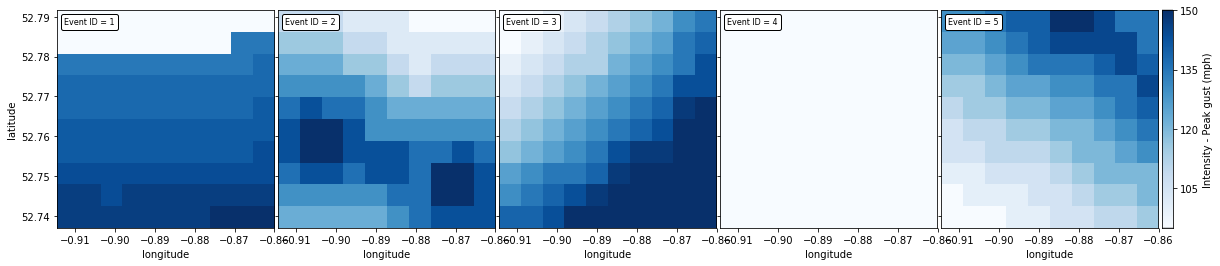

In [8]:
footprints_with_hazard = footprints.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_index', right_on='bin_index').merge(
    area_peril_dictionary, how='inner', 
    left_on='area_peril_id', right_on='areaperil_id')

fig = plt.figure(figsize=(20,10))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 5),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

for idx, ax in enumerate(grid):
    a = np.zeros([10, 10])
    for __, row in footprints_with_hazard[footprints_with_hazard.event_id == idx+1].iterrows():
       i, j = row.gridcell.split('-')
       a[int(i)-1, int(j)-1] = row.interpolation
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'), 
                   extent=(
                       min(area_peril_dictionary.lon), max(area_peril_dictionary.lon), 
                       min(area_peril_dictionary.lat), max(area_peril_dictionary.lat)))
    ax.set_xlabel("longitude")
    ax.set_ylabel("latitude")
    at = AnchoredText(
        "Event ID = {}".format(idx + 1),
        prop=dict(size=8),
        frameon=True,
        loc=2,
    )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Intensity - Peak gust (mph)")

plt.show()

Lets have a look at the data contained in the Damage Bin dictionary file. 
Note that the dictionary is required for model execution.

In [9]:
damage_bin_dictionary = pd.read_csv("./model_data/PiWind/damage_bin_dict.csv")
damage_bin_dictionary.head()

,bin_index,bin_from,bin_to,interpolation,interval_type
0,1,0.0,0.0,0.00,1203
1,2,0.0,0.1,0.05,1200
2,3,0.1,0.2,0.15,1202
3,4,0.2,0.3,0.25,1202
4,5,0.3,0.4,0.35,1202


Lets have a look at the data contained in the Vulnerability file. 

In [10]:
vulnerabilities = pd.read_csv("./model_data/PiWind/vulnerability.csv")
vulnerabilities.head()

,vulnerability_id,intensity_bin_index,damage_bin_index,prob
0,1,1,1,0.654
1,1,1,2,0.146
2,1,1,3,0.060
3,1,1,4,0.140
4,1,2,1,0.654


The model has seperate vulnerability curves for Residential, Commerical and Industrial occupancies. 
Lets visualise these curves.

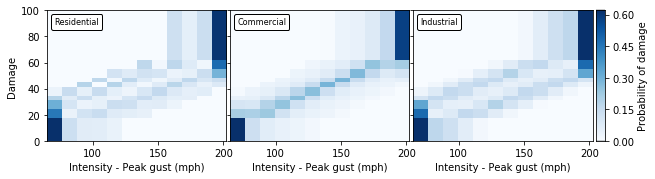

In [11]:
vulnerabilities_with_hazard_and_damage = vulnerabilities.merge(
    intensity_bin_dictionary, how='inner', 
    left_on='intensity_bin_index', right_on='bin_index').merge(
    damage_bin_dictionary, how='inner',
    suffixes=["_i", "_d"], left_on='damage_bin_index', right_on='bin_index')

fig = plt.figure(figsize=(10,20))

grid = AxesGrid(fig, 111,
                nrows_ncols=(1, 3),
                axes_pad=0.05,
                share_all=True,
                label_mode="L",
                cbar_location="right",
                cbar_mode="single",
                )

labels = ["Residential", "Commercial", "Industrial"]
for idx, ax in enumerate(grid):
    a = np.zeros((29, 12))
    for index, row in vulnerabilities_with_hazard_and_damage[
        vulnerabilities_with_hazard_and_damage.vulnerability_id == idx + 1].iterrows():
        a[int(row.bin_index_i-1), 11-int(row.bin_index_d-1)] = row.prob
    
    im = ax.imshow(a, cmap=plt.cm.get_cmap('Blues'),
                   extent=(
                       min(intensity_bin_dictionary.interpolation), max(intensity_bin_dictionary.interpolation), 
                       min(damage_bin_dictionary.interpolation) * 100, max(damage_bin_dictionary.interpolation) * 100))

    at = AnchoredText(labels[idx],
                  prop=dict(size=8), frameon=True,
                  loc=2,
                  )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    ax.set_xlabel("Intensity - Peak gust (mph)")
    ax.set_ylabel("Damage")

grid[0].cax.colorbar(im)
cax = grid.cbar_axes[0]
axis = cax.axis[cax.orientation]
axis.label.set_text("Probability of damage")

plt.show()

To run the model we need some test exxposure data. Lets have a look at an example Location and Account file. 

In [12]:
test_locations = pd.read_csv('./tests/data/SourceLocPiWind.csv')
test_locations.head()

,ACCNTNUM,LOCNUM,POSTALCODE,STATECODE,COUNTYCODE,LATITUDE,LONGITUDE,BLDGSCHEME,BLDGCLASS,OCCSCHEME,...,WSCV5DED,WSCV6DED,WSCV7DED,WSCV8DED,WSCV9DED,WSCV10DED,WSSITELIM,WSSITEDED,WSCOMBINEDLIM,WSCOMBINEDDED
0,11111,10002082046,LE13 0HL,1,1,-52.766981,-0.895470,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
1,11111,10002082047,LE13 0HL,1,1,52.766980,-0.895366,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
2,11111,10002082048,LE13 0HL,1,1,52.766978,-0.895248,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
3,11111,10002082049,LE13 0HL,1,1,52.766961,-0.895474,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0
4,11111,10002082050,LE13 0HL,1,1,52.766958,-0.895353,RMS,0,R,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_accounts = pd.read_csv('./tests/data/SourceAccPiWind.csv')
test_accounts.head()

,ACCNTNUM,POLICYNUM,POLICYTYPE,UNDCOVAMT,PARTOF,MINDEDAMT,MAXDEDAMT,BLANDEDAMT,BLANLIMAMT
0,11111,Layer1,2,500000,5000000,0,0,0,0.3
1,11111,Layer2,2,5500000,100000000,0,0,0,0.3


To run the model, we also need to define some analysis settings. Lets have a look at an example settings file.

In [14]:
with open('./analysis_settings.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "analysis_settings": {
  "gul_summaries": [
   {
    "leccalc": {
     "outputs": {
      "full_uncertainty_aep": true, 
      "full_uncertainty_oep": true
     }, 
     "return_period_file": true
    }, 
    "lec_output": true, 
    "eltcalc": true, 
    "aalcalc": true, 
    "id": 1
   }
  ], 
  "source_tag": "piwind", 
  "il_summaries": [], 
  "analysis_tag": 13, 
  "number_of_samples": 10, 
  "model_version_id": "PiWind", 
  "module_supplier_id": "OasisLMF", 
  "gul_threshold": 0, 
  "gul_output": true, 
  "exposure_location": "L:", 
  "prog_id": 12, 
  "model_settings": {
   "event_set": "P", 
   "peril_wind": true
  }
 }
}


We can now run the model using the Oasis MDK.

In [15]:
with open('./mdk-oasislmf-piwind.json', 'r') as myfile:
    analysis_settings=json.loads(myfile.read().replace('\n', ''))
print(json.dumps(analysis_settings, indent=True))

{
 "canonical_to_model_exposures_transformation_file_path": "flamingo/PiWind/Files/TransformationFiles/MappingMapTopiwind_modelloc.xslt", 
 "model_version_file_path": "keys_data/PiWind/ModelVersion.csv", 
 "canonical_exposures_profile_json_path": "oasislmf-piwind-canonical-loc-profile.json", 
 "source_exposures_validation_file_path": "flamingo/PiWind/Files/ValidationFiles/Generic_Windstorm_SourceLoc.xsd", 
 "model_data_path": "model_data/PiWind", 
 "source_to_canonical_exposures_transformation_file_path": "flamingo/PiWind/Files/TransformationFiles/MappingMapToGeneric_Windstorm_CanLoc_A.xslt", 
 "canonical_exposures_validation_file_path": "flamingo/PiWind/Files/ValidationFiles/Generic_Windstorm_CanLoc_B.xsd", 
 "canonical_account_profile_json_path": "oasislmf-piwind-canonical-acc-profile.json", 
 "source_exposures_file_path": "tests/data/SourceLocPiWind.csv", 
 "lookup_package_path": "src/keys_server", 
 "analysis_settings_json_file_path": "analysis_settings.json", 
 "keys_data_path": "

In [16]:
! rm -rf /tmp/analysis_test
! oasislmf model run -C mdk-oasislmf-piwind.json -r /tmp/analysis_test

Creating temporary folder /tmp/analysis_test/tmp for Oasis files
Getting model info and creating lookup service instance
STARTED: keys_server.PiWind.PiWindKeysLookup.__init__
STARTED: oasislmf.keys.lookup.__init__
COMPLETED: oasislmf.keys.lookup.__init__ in 0.0s
COMPLETED: keys_server.PiWind.PiWindKeysLookup.__init__ in 0.01s
	{u'model_id': 'PiWind', u'supplier_id': 'OasisLMF', u'model_version_id': '0.0.0.1'}, <keys_server.PiWind.PiWindKeysLookup.PiWindKeysLookup object at 0x7f2e8479f390>
Creating Oasis model object
	<class 'oasislmf.models.model.OasisModel'>: {'_key': u'OasisLMF/PiWind/0.0.0.1', '_supplier_id': 'OasisLMF', '_model_version_id': '0.0.0.1', '_resources': {'canonical_to_model_exposures_transformation_file_path': u'/home/pinkerton/git/OasisPiWind/flamingo/PiWind/Files/TransformationFiles/MappingMapTopiwind_modelloc.xslt', 'oasis_files_path': '/tmp/analysis_test/tmp', 'lookup': <keys_server.PiWind.PiWindKeysLookup.PiWindKeysLookup object at 0x7f2e8479f390>, 'oasis_files_pip

COMPLETED: oasislmf.model_execution.runner.run in 2.05s
Loss outputs generated in /tmp/analysis_test/output


Lets visualize the output of our analysis.

Text(0,0.5,'Loss')

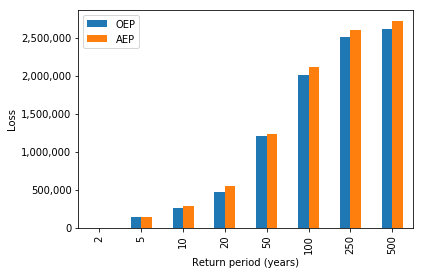

In [17]:
analysis_directory = "/tmp/analysis_test"
gul_aep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_aep.csv"))
gul_oep = pd.read_csv(os.path.join(analysis_directory, "output", "gul_S1_leccalc_full_uncertainty_oep.csv"))
eps = pd.merge(gul_oep, gul_aep, on=["summary_id", "return_period"], suffixes=["_oep", "_aep"])
eps = eps.sort_values(by="return_period", ascending=True)
fig, ax = plt.subplots()
eps.plot(ax=ax, kind='bar', x='return_period', y=["loss_oep", "loss_aep"])
ax.set_yticklabels(['{:,}'.format(int(x)) for x in ax.get_yticks().tolist()])
ax.set_xticklabels(['{:,}'.format(int(x)) for x in eps.return_period])
plt.legend(('OEP', 'AEP'))
ax.set_xlabel("Return period (years)")
ax.set_ylabel("Loss")